In [300]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 20px;
}
.dataframe td {
    font-size: 18px;
}
</style>

# CASACV Project

## Load MRI data

In [301]:
import os
import pylab as plt

t1_file = os.path.join(os.getcwd(), "mri_data", "T1_preprocessed.nii.gz")
t2_file = os.path.join(os.getcwd(), "mri_data", "T2_preprocessed.nii.gz")
flair_file = os.path.join(os.getcwd(), "mri_data", "FLAIR_preprocessed.nii.gz")

import nibabel as nib
t1_img = nib.load(t1_file)
t2_img = nib.load(t2_file)
flair_img = nib.load(flair_file)

G_t1_data = t1_img.get_fdata()
G_t2_data = t2_img.get_fdata()
G_flair_data = flair_img.get_fdata()

## T1, T2 and FLAIR modalities

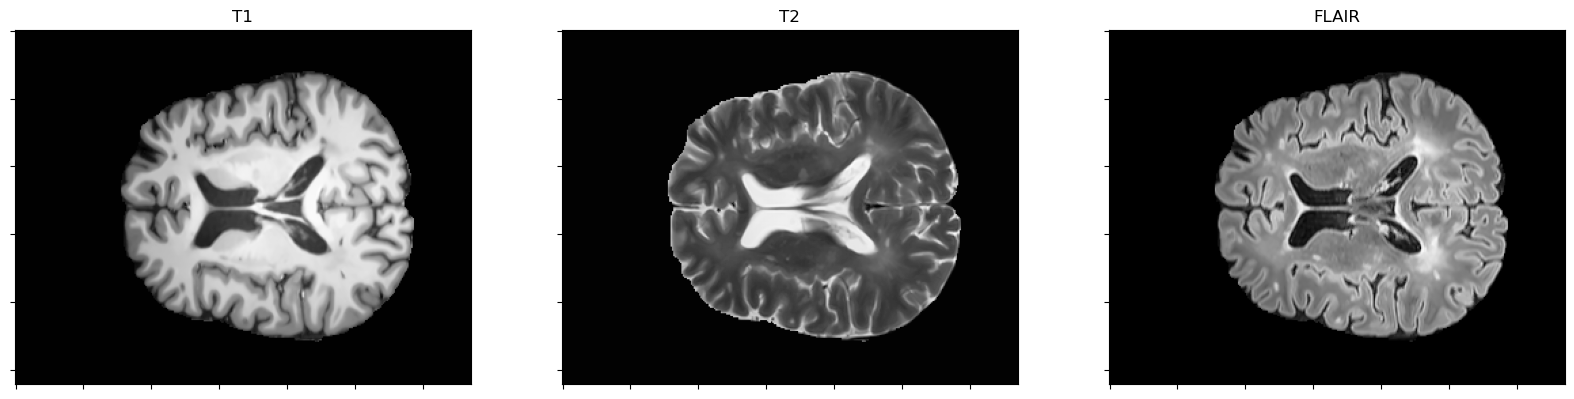

In [302]:
G_layer_for_display = 218

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('T1')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.imshow(G_t1_data[:, :, G_layer_for_display], cmap="Greys_r")

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('T2')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.imshow(G_t2_data[:, :, G_layer_for_display], cmap="Greys_r")

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('FLAIR')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.imshow(G_flair_data[:, :, G_layer_for_display], cmap="Greys_r")

## Remove layers with only black pixels

We picked layer **218** to plot the images, but if we take a look to the layers at the beginning and at the end of the range, we can see that many of the present only black pixels. Theses layers are not useful, so we can remove them and save computation time on the next operations.

In [303]:
import numpy as np
import pandas as pd

def get_first_and_last_nonblack_layers(data, size):
    first = size
    last = 0
    for s in range(size):
        image_slice = np.array(data[:, :, s])
        max_pixel_value = np.max(image_slice)

        if max_pixel_value > 0:
            if s < first:
                first = s
            if s > last:
                last = s
    
    return first, last

t1_min, t1_max = get_first_and_last_nonblack_layers(G_t1_data, G_t1_data.shape[2])
t2_min, t2_max = get_first_and_last_nonblack_layers(G_t2_data, G_t2_data.shape[2])
flair_min, flair_max = get_first_and_last_nonblack_layers(G_flair_data, G_flair_data.shape[2])

G_layers_min_all = max(t1_min, t2_min, flair_min)
G_layers_max_all = min(t1_max, t2_max, flair_max)
G_layer_for_display = G_layer_for_display - G_layers_min_all

original_t1_layers = G_t1_data.shape[2]
original_t2_layers = G_t2_data.shape[2]
original_flair_layers = G_flair_data.shape[2]

G_t1_data = G_t1_data[:, :, G_layers_min_all:G_layers_max_all+1]
G_t2_data = G_t2_data[:, :, G_layers_min_all:G_layers_max_all+1]
G_flair_data = G_flair_data[:, :, G_layers_min_all:G_layers_max_all+1]

table_array = np.array([
    ["original layers", original_t1_layers, original_t2_layers, original_flair_layers],
    ["layers after reduction", G_t1_data.shape[2], G_t2_data.shape[2], G_flair_data.shape[2]],
    ["removed layers", original_t1_layers - G_t1_data.shape[2], original_t2_layers - G_t2_data.shape[2], original_flair_layers - G_flair_data.shape[2]]
])

pd.DataFrame(table_array, columns=['', 'T1', 'T2', 'FLAIR'])

,,T1,T2,FLAIR
0,original layers,336,336,336
1,layers after reduction,181,181,181
2,removed layers,155,155,155


## Crop images

As can be seen in the above images, a large parte of the image is just black background. This background is not useful for the purposes of the project, so we can remove it. By removing it we also decrease the size of the images, which should improve the time taken by the next processing steps.

In [304]:
from PIL import Image
import numpy as np

def compute_bounding_boxes_for_modality(data, size):
    bounding_pixels_for_slice = [(0, 0, 0, 0)] * size

    for s in range(size):
        image_slice = data[:, :, s]

        image = Image.fromarray(image_slice.astype(np.uint8))
        image_pixels = list(image.getdata())

        max_row = image.height
        max_col = image.width

        first_nonblack_row = 0
        last_nonblack_row = 0
        first_nonblack_col = 0
        last_nonblack_col = 0

        for row in range(max_row):
            for col in range(max_col):
                idx = col + (row * max_col)

                if image_pixels[idx] > 0:
                    if first_nonblack_col == 0 or first_nonblack_col > col:
                        first_nonblack_col = col
                    if last_nonblack_col == 0 or last_nonblack_col < col:
                        last_nonblack_col = col
                    last_nonblack_row = row
                    if first_nonblack_row == 0:
                        first_nonblack_row = row
            
        bounding_pixels_for_slice[s] = (first_nonblack_col, first_nonblack_row, last_nonblack_col, last_nonblack_row)

    return bounding_pixels_for_slice

def get_max_bounding_box(bounding_boxes, max_x, max_y):
    top = len(bounding_boxes)

    first_nonblack_row = max_y
    first_nonblack_col = max_x
    last_nonblack_row = 0
    last_nonblack_col = 0

    for i in range(1, top):
        if bounding_boxes[i] == (0, 0, 0, 0): continue

        if bounding_boxes[i][0] < first_nonblack_col:
            first_nonblack_col = bounding_boxes[i][0]

        if bounding_boxes[i][1] < first_nonblack_row:
            first_nonblack_row = bounding_boxes[i][1]

        if bounding_boxes[i][2] > last_nonblack_col:
            last_nonblack_col = bounding_boxes[i][2]

        if bounding_boxes[i][3] > last_nonblack_row:
            last_nonblack_row = bounding_boxes[i][3]

    return (first_nonblack_col, first_nonblack_row, last_nonblack_col, last_nonblack_row)


# to crop the images, first we need to compute the bounding boxes for each slice
bounding_boxes_t1 = compute_bounding_boxes_for_modality(G_t1_data, G_t1_data.shape[2])
bounding_boxes_t2 = compute_bounding_boxes_for_modality(G_t2_data, G_t2_data.shape[2])
bounding_boxes_flair = compute_bounding_boxes_for_modality(G_flair_data, G_flair_data.shape[2])

# then we have to compute a bounding box that fits all other bounding boxes
max_bounding_box_t1 = get_max_bounding_box(bounding_boxes_t1, G_t1_data.shape[1], G_t1_data.shape[0])
max_bounding_box_t2 = get_max_bounding_box(bounding_boxes_t2, G_t2_data.shape[1], G_t1_data.shape[0])
max_bounding_box_flair = get_max_bounding_box(bounding_boxes_flair, G_flair_data.shape[1], G_flair_data.shape[0])

# finally, we calculate the max bounding box between all modalities
G_max_bounding_box_all = get_max_bounding_box([max_bounding_box_t1, max_bounding_box_t2, max_bounding_box_flair], G_t1_data.shape[1], G_t1_data.shape[0])

print("max bounding box:", G_max_bounding_box_all)

max bounding box: (76, 24, 302, 234)


In [305]:
def normalize(im):
    # Normalize image to range 0..1
    min, max = im.min(), im.max()
    return (im.astype(float)-min)/(max-min)

def scale(im):
    return im * 255.999

def normalize_and_scale(im):
    return scale(normalize(im))

### Cropping results

In [306]:
from pathlib import Path
CROPPED_IMAGES_OUTPUT_FOLDER = os.path.join(os.getcwd(), "cropped_images")
Path(CROPPED_IMAGES_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

def __crop_image(size, data, img_type):
    for s in range(size):
        normalized_and_scaled_img = normalize_and_scale(data[:, :, s])
        original_img = Image.fromarray(normalized_and_scaled_img)
        cropped_img = original_img.crop(G_max_bounding_box_all)
        cropped_img = cropped_img.convert("L") # preserve grayscale

        result_name = img_type + '_' + str(s) + '.png'
        result_final_path = os.path.join(CROPPED_IMAGES_OUTPUT_FOLDER, result_name)
        cropped_img.save(result_final_path)

def crop_images():
    __crop_image(G_t1_data.shape[2], G_t1_data, "T1")
    __crop_image(G_t2_data.shape[2], G_t2_data, "T2")
    __crop_image(G_flair_data.shape[2], G_flair_data, "FLAIR")

In [307]:
crop_images()

,,T1,T2,FLAIR
0,original dimensions,336x261,336x261,336x261
1,cropped dimensions,226x210,226x210,226x210
2,original pixels,87696,87696,87696
3,removed pixels,40236,40236,40236
4,percentage difference,45.88%,45.88%,45.88%


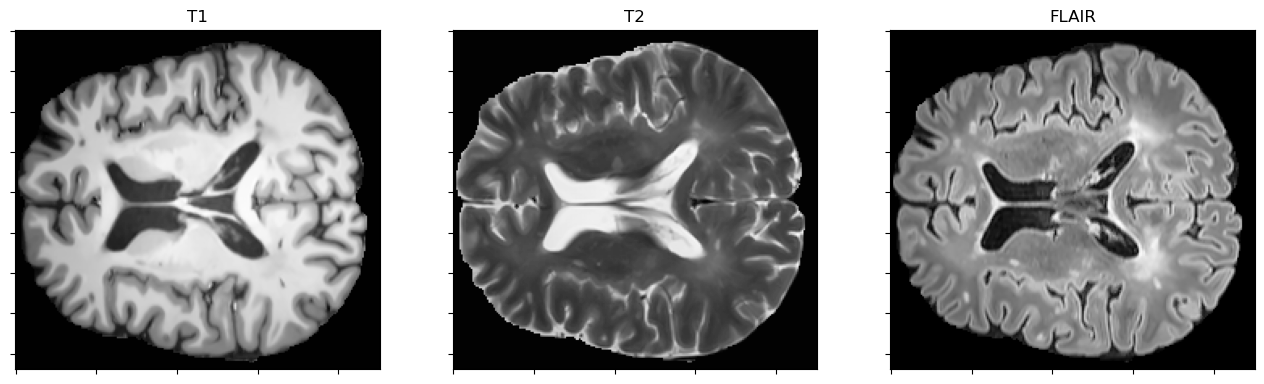

In [308]:
import pandas as pd

original_t1 = Image.fromarray(G_t1_data[:, :, G_layer_for_display])
original_t2 = Image.fromarray(G_t2_data[:, :, G_layer_for_display])
original_flair = Image.fromarray(G_flair_data[:, :, G_layer_for_display])

fig = plt.figure(figsize=(16, 8))

G_cropped_t1 = Image.open(os.path.join(CROPPED_IMAGES_OUTPUT_FOLDER, "T1_" + str(G_layer_for_display) + ".png"))
ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('T1')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.imshow(G_cropped_t1, cmap="Greys_r")

G_cropped_t2 = Image.open(os.path.join(CROPPED_IMAGES_OUTPUT_FOLDER, "T2_" + str(G_layer_for_display) + ".png"))
ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('T2')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.imshow(G_cropped_t2, cmap="Greys_r")

G_cropped_flair = Image.open(os.path.join(CROPPED_IMAGES_OUTPUT_FOLDER, "FLAIR_" + str(G_layer_for_display) + ".png"))
ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('FLAIR')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.imshow(G_cropped_flair, cmap="Greys_r")

def get_percentage_difference(current, previous):
    return (abs(current - previous) / previous) * 100.0

original_t1_pixels = original_t1.height * original_t1.width
cropped_t1_pixels = G_cropped_t1.height * G_cropped_t1.width
t1_removed_pixels = original_t1_pixels - cropped_t1_pixels
pixels_percentage_difference_t1 = "{:.2f}%".format(get_percentage_difference(cropped_t1_pixels, original_t1_pixels))

original_t2_pixels = original_t2.height * original_t2.width
cropped_t2_pixels = G_cropped_t2.height * G_cropped_t2.width
t2_removed_pixels = original_t2_pixels - cropped_t2_pixels
pixels_percentage_difference_t2 = "{:.2f}%".format(get_percentage_difference(cropped_t2_pixels, original_t2_pixels))

original_flair_pixels = original_flair.height * original_flair.width
cropped_flair_pixels = G_cropped_flair.height * G_cropped_flair.width
flair_removed_pixels = original_flair_pixels - cropped_flair_pixels
pixels_percentage_difference_flair = "{:.2f}%".format(get_percentage_difference(cropped_flair_pixels, original_flair_pixels))

def pretty_print_image_dimensions(image):
    return f"{image.width}x{image.height}"

table_array = np.array([
    ["original dimensions", pretty_print_image_dimensions(original_t1), pretty_print_image_dimensions(original_t2), pretty_print_image_dimensions(original_flair)],
    ["cropped dimensions", pretty_print_image_dimensions(G_cropped_t1), pretty_print_image_dimensions(G_cropped_t2), pretty_print_image_dimensions(G_cropped_flair)],
    ["original pixels", original_t1_pixels, original_t2_pixels, original_flair_pixels],
    ["removed pixels", t1_removed_pixels, t2_removed_pixels, flair_removed_pixels],
    ["percentage difference", pixels_percentage_difference_t1, pixels_percentage_difference_t2, pixels_percentage_difference_flair],
])

pd.DataFrame(table_array, columns=['', 'T1', 'T2', 'FLAIR'])

## RGB Images

Make RGB Images by using permutations of (T1, T2, FLAIR) on the R G B channels. 

For example, an image can be generated using T1 on the R channel, T2 on the G channel and FLAIR on the B channel.
Values of the pixels for each modality need to be normalized and scaled before computing the RGB image.

In [309]:
from PIL import Image
import numpy as np

RGB_IMAGES_OUTPUT_FOLDER = os.path.join(os.getcwd(), "rgb_images")

my_array = np.array([np.asarray(G_cropped_t1), np.asarray(G_cropped_t2), np.asarray(G_cropped_flair)])

def index_to_type(index):
    if index == 0: return "T1"
    if index == 1: return "T2"
    if index == 2: return "FLAIR"

from pathlib import Path
Path(RGB_IMAGES_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

# compute permutations
for x in range(3):
    for y in range(3):
        for z in range(3):
            if x == y or x == z or z == y: continue

            permuted_array = my_array[[x, y, z]]

            result = np.dstack((permuted_array[0], permuted_array[1], permuted_array[2]))
            result = Image.fromarray(result.astype(np.uint8))

            result_name = index_to_type(x) + '_' + index_to_type(y) + '_' + index_to_type(z) + '.png'
            result_final_path = os.path.join(RGB_IMAGES_OUTPUT_FOLDER, result_name)
            result.save(result_final_path)

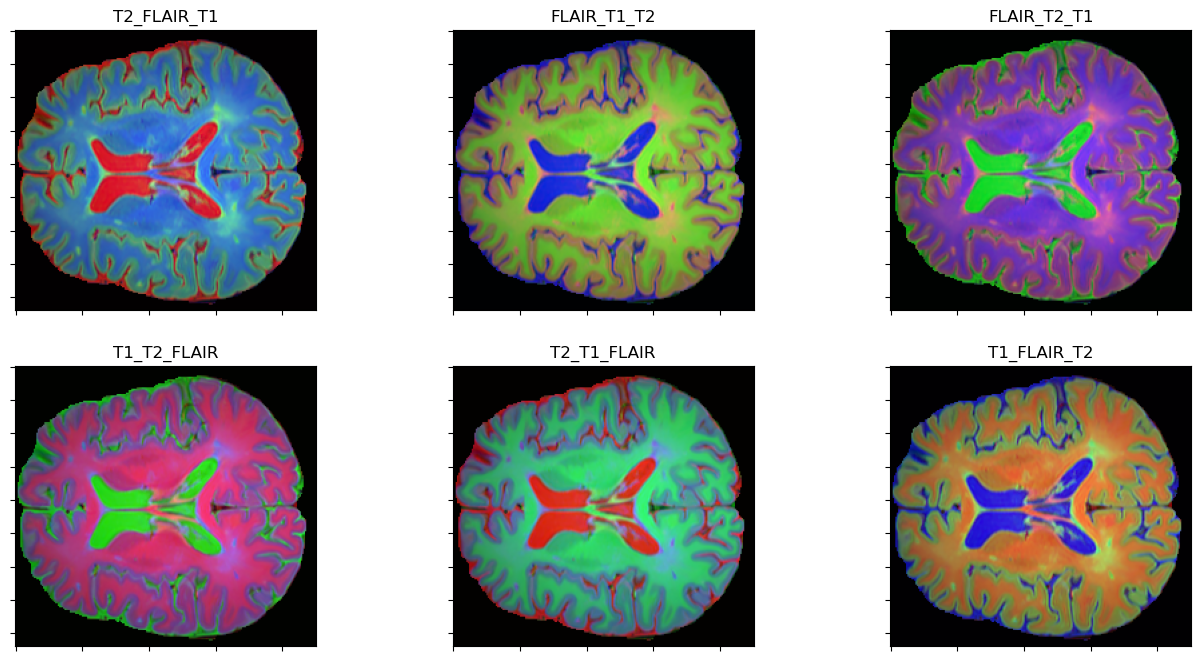

In [310]:
fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 2
i = 1

def drop_extension_from_filename(filename):
    return os.path.splitext(filename)[0]

for filename in os.listdir(RGB_IMAGES_OUTPUT_FOLDER):
    with (Image.open(os.path.join(RGB_IMAGES_OUTPUT_FOLDER, filename))) as image:
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(drop_extension_from_filename(filename))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.imshow(np.asarray(image))
        i = i + 1

plt.show()

## Graph class

The graph will be represented by an adjacency list.

In [311]:
import math

class Node:
    def __init__(self, value):
        self.vertex = value
        self.next = None
        self.weight = None

class Graph:
    def __init__(self, num):
        self.V = num
        self.node_list = [None] * self.V
        self.max_weight = 0
        self.min_weight = math.inf

    def add_edge(self, s, d, w):
        node = Node(d)
        node.next = self.node_list[s]
        node.weight = w
        self.node_list[s] = node

        if w > self.max_weight:
            self.max_weight = w
        if w < self.min_weight:
            self.min_weight = w

    def get_min_max_weight(self):
        return self.min_weight, self.max_weight

    def get_adjacency_list(self):
        adj_list = []

        for idx in range(self.V):
            row = []
            node = self.node_list[idx]
            
            if node != None:
                row.append(node.vertex)
            while node:
                if node.next != None:
                    row.append(node.next.vertex)
                node = node.next
            adj_list.append(row)

        # Initialize an empty list to store edges
        edges = []

        # Iterate over the adjacency list
        for node, neighbors in enumerate(adj_list):
            for neighbor in neighbors:
                edges.append((node, neighbor))
        
        return edges

    def get_edges_weight_list(self):
        weight_list = []

        for idx in range(self.V):
            node = self.node_list[idx]
            while node:
                weight_list.append([node.weight])
                node = node.next
        
        return weight_list

    def get_num_of_vertices(self):
        return self.V

    def __print_graph(self, file=None):
        for i in range(self.V):
            print("Vertex " + str(i) + ":", end="", file=file)
            temp = self.node_list[i]
            while temp:
                print(" -> {}, w:{}".format(temp.vertex, temp.weight), end="", file=file)
                temp = temp.next
            print("", file=file)

    def print_graph(self):
        self.__print_graph()

    def print_graph_to_file(self, filename):
        with open(filename, 'w') as f:
            self.__print_graph(file=f)

## Build the graph for each RGB image previously generated

Edges where at least one vertex is a background pixel are omitted from the graph.

In [312]:
import math

def compute_pixel_graph(image):
    max_row = image.height
    max_col = image.width

    image = list(image.getdata())

    graph = Graph(len(image))

    def is_pixel_black(pixel):
        return pixel == (2, 0, 1) or pixel == (0, 1, 2) or pixel == (0, 2, 1) or pixel == (1, 2, 0) or pixel == (2, 1, 0) or pixel == (1, 0, 2)

    def compute_rgb_distance(rgb1, rgb2):
        r_sq = math.pow((rgb2[0] - rgb1[0]), 2)
        g_sq = math.pow((rgb2[1] - rgb1[1]), 2)
        b_sq = math.pow((rgb2[2] - rgb1[2]), 2)

        return math.sqrt(r_sq + g_sq + b_sq)

    def add_edges_for_adjacent_pixels(row, col):
        idx = col + (row * max_col)

        def add_edge_if_not_black(current_pixel, neighbor_pixel):
            if not is_pixel_black(image[neighbor_pixel]):
                weight = compute_rgb_distance(image[current_pixel], image[neighbor_pixel])
                graph.add_edge(current_pixel, neighbor_pixel, weight)

        if row > 0 and col > 0:
            top_left_idx = (col - 1) + ((row - 1) * max_col)
            add_edge_if_not_black(idx, top_left_idx)

        if row > 0:
            top_mid_idx = col + ((row - 1) * max_col)
            add_edge_if_not_black(idx, top_mid_idx)

        if row > 0 and col < max_col - 1:
            top_right_idx = (col + 1) + ((row - 1) * max_col)
            add_edge_if_not_black(idx, top_right_idx)

        if row < max_row - 1 and col != 0:
            bottom_left_idx = (col - 1) + ((row + 1) * max_col)
            add_edge_if_not_black(idx, bottom_left_idx)

        if row < max_row - 1:
            bottom_mid_idx = col + ((row + 1) * max_col)
            add_edge_if_not_black(idx, bottom_mid_idx)

        if row < max_row - 1 and col < max_col - 1:
            bottom_right_idx = (col + 1) + ((row + 1) * max_col)
            add_edge_if_not_black(idx, bottom_right_idx)
        
        if col > 0:
            mid_left_idx = (col - 1) + (row * max_col)
            add_edge_if_not_black(idx, mid_left_idx)
        
        if col < max_col - 1:
            mid_right_idx = (col + 1) + (row * max_col)
            add_edge_if_not_black(idx, mid_right_idx)


    for row in range(max_row):
        for col in range(max_col):
            idx = col + (row * max_col)
            if not is_pixel_black(image[idx]):
                add_edges_for_adjacent_pixels(row, col)

    return graph

In [313]:
import os
from pathlib import Path

IMAGES_GRAPHS_OUTPUT_FOLDER = os.path.join(os.getcwd(), "graphs")

Path(IMAGES_GRAPHS_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

G_graphs = {}

def drop_extension_from_filename(filename):
    return os.path.splitext(filename)[0]

for filename in os.listdir(RGB_IMAGES_OUTPUT_FOLDER):
    with (Image.open(os.path.join(RGB_IMAGES_OUTPUT_FOLDER, filename))) as image:
        graph = compute_pixel_graph(image)
        G_graphs[drop_extension_from_filename(filename)] = graph
        # graph.print_graph_to_file(os.path.join(IMAGES_GRAPHS_OUTPUT_FOLDER, drop_extension_from_filename(filename) + ".txt"))

## Consensus data

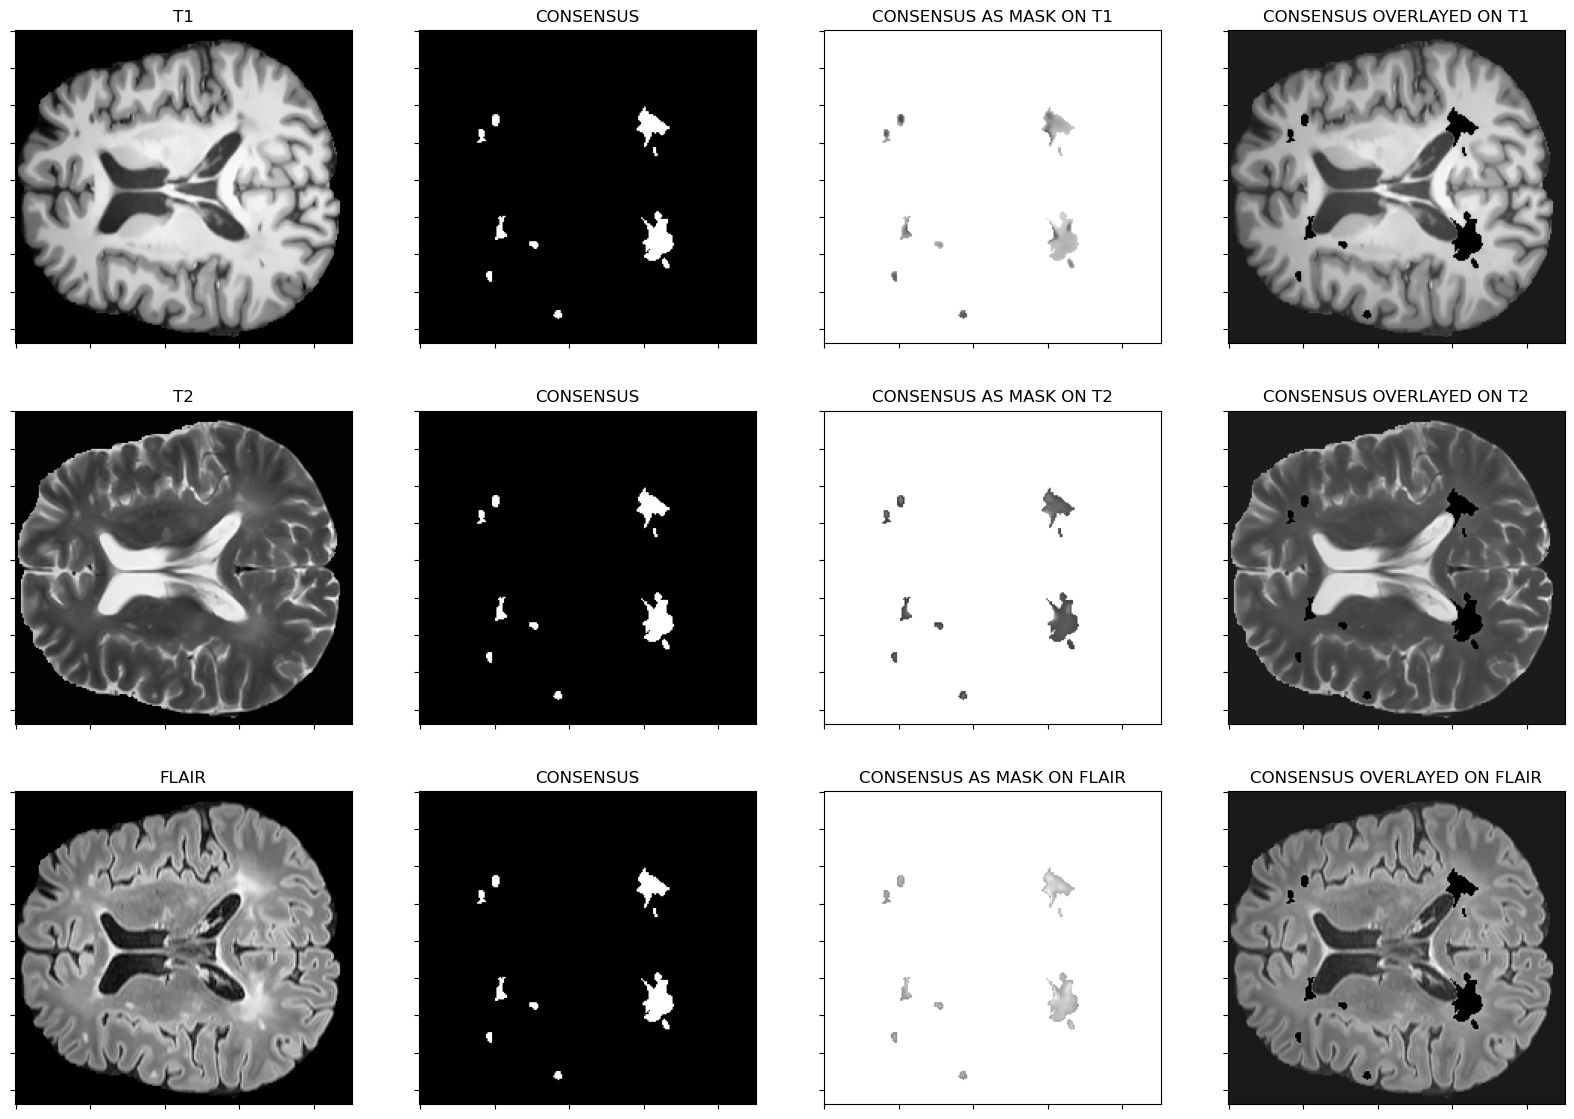

In [314]:
import os
import pylab as plt
import numpy as np
import nibabel as nib

consensus_file = os.path.join(os.getcwd(), "mri_data", "Consensus.nii.gz")
consensus_img = nib.load(consensus_file)
consensus_data = consensus_img.get_fdata()

G_cropped_t1_rgba = G_cropped_t1.convert("RGBA")
G_cropped_t2_rgba = G_cropped_t2.convert("RGBA")
G_cropped_flair_rgba = G_cropped_flair.convert("RGBA")

cropped_t1_rgba = np.array(G_cropped_t1_rgba)
cropped_t2_rgba = np.array(G_cropped_t2_rgba)
cropped_flair_rgba = np.array(G_cropped_flair_rgba)

consensus_data = consensus_data[:, :, G_layers_min_all:G_layers_max_all+1]

consensus_data = np.array(consensus_data[:, :, G_layer_for_display])
cropped_consensus_data = consensus_data[G_max_bounding_box_all[1]:G_max_bounding_box_all[3], G_max_bounding_box_all[0]:G_max_bounding_box_all[2]]

cropped_t1_rgba_masked = np.array(cropped_t1_rgba)
cropped_t2_rgba_masked = np.array(cropped_t2_rgba)
cropped_flair_rgba_masked = np.array(cropped_flair_rgba)

for x in range(G_cropped_t1.height):
    for y in range(G_cropped_t1.width):
        if cropped_consensus_data[x][y] == 0:
            cropped_t1_rgba[x][y][3] = 230
            cropped_t2_rgba[x][y][3] = 230
            cropped_flair_rgba[x][y][3] = 230
            cropped_t1_rgba_masked[x][y][3] = 0
            cropped_t2_rgba_masked[x][y][3] = 0
            cropped_flair_rgba_masked[x][y][3] = 0
        else:
            cropped_t1_rgba[x][y] = [1, 1, 1, 255]
            cropped_t2_rgba[x][y] = [1, 1, 1, 255]
            cropped_flair_rgba[x][y] = [1, 1, 1, 255]

t1_overlayed_consensus = Image.fromarray(cropped_t1_rgba)
t2_overlayed_consensus = Image.fromarray(cropped_t2_rgba)
flair_overlayed_consensus = Image.fromarray(cropped_flair_rgba)

images_to_plot = [
    [G_cropped_t1, "T1"],
    [cropped_consensus_data, "CONSENSUS"],
    [cropped_t1_rgba_masked, "CONSENSUS AS MASK ON T1"],
    [t1_overlayed_consensus, "CONSENSUS OVERLAYED ON T1"],
    [G_cropped_t2, "T2"],
    [cropped_consensus_data, "CONSENSUS"],
    [cropped_t2_rgba_masked, "CONSENSUS AS MASK ON T2"],
    [t2_overlayed_consensus, "CONSENSUS OVERLAYED ON T2"],
    [G_cropped_flair, "FLAIR"],
    [cropped_consensus_data, "CONSENSUS"],
    [cropped_flair_rgba_masked, "CONSENSUS AS MASK ON FLAIR"],
    [flair_overlayed_consensus, "CONSENSUS OVERLAYED ON FLAIR"],
]

fig = plt.figure(figsize=(20, 14))

for idx in range(len(images_to_plot)):
    ax1 = fig.add_subplot(3, 4, idx + 1)
    ax1.title.set_text(images_to_plot[idx][1])
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    plt.imshow(images_to_plot[idx][0], cmap="Greys_r")

## Consensus on RGB images

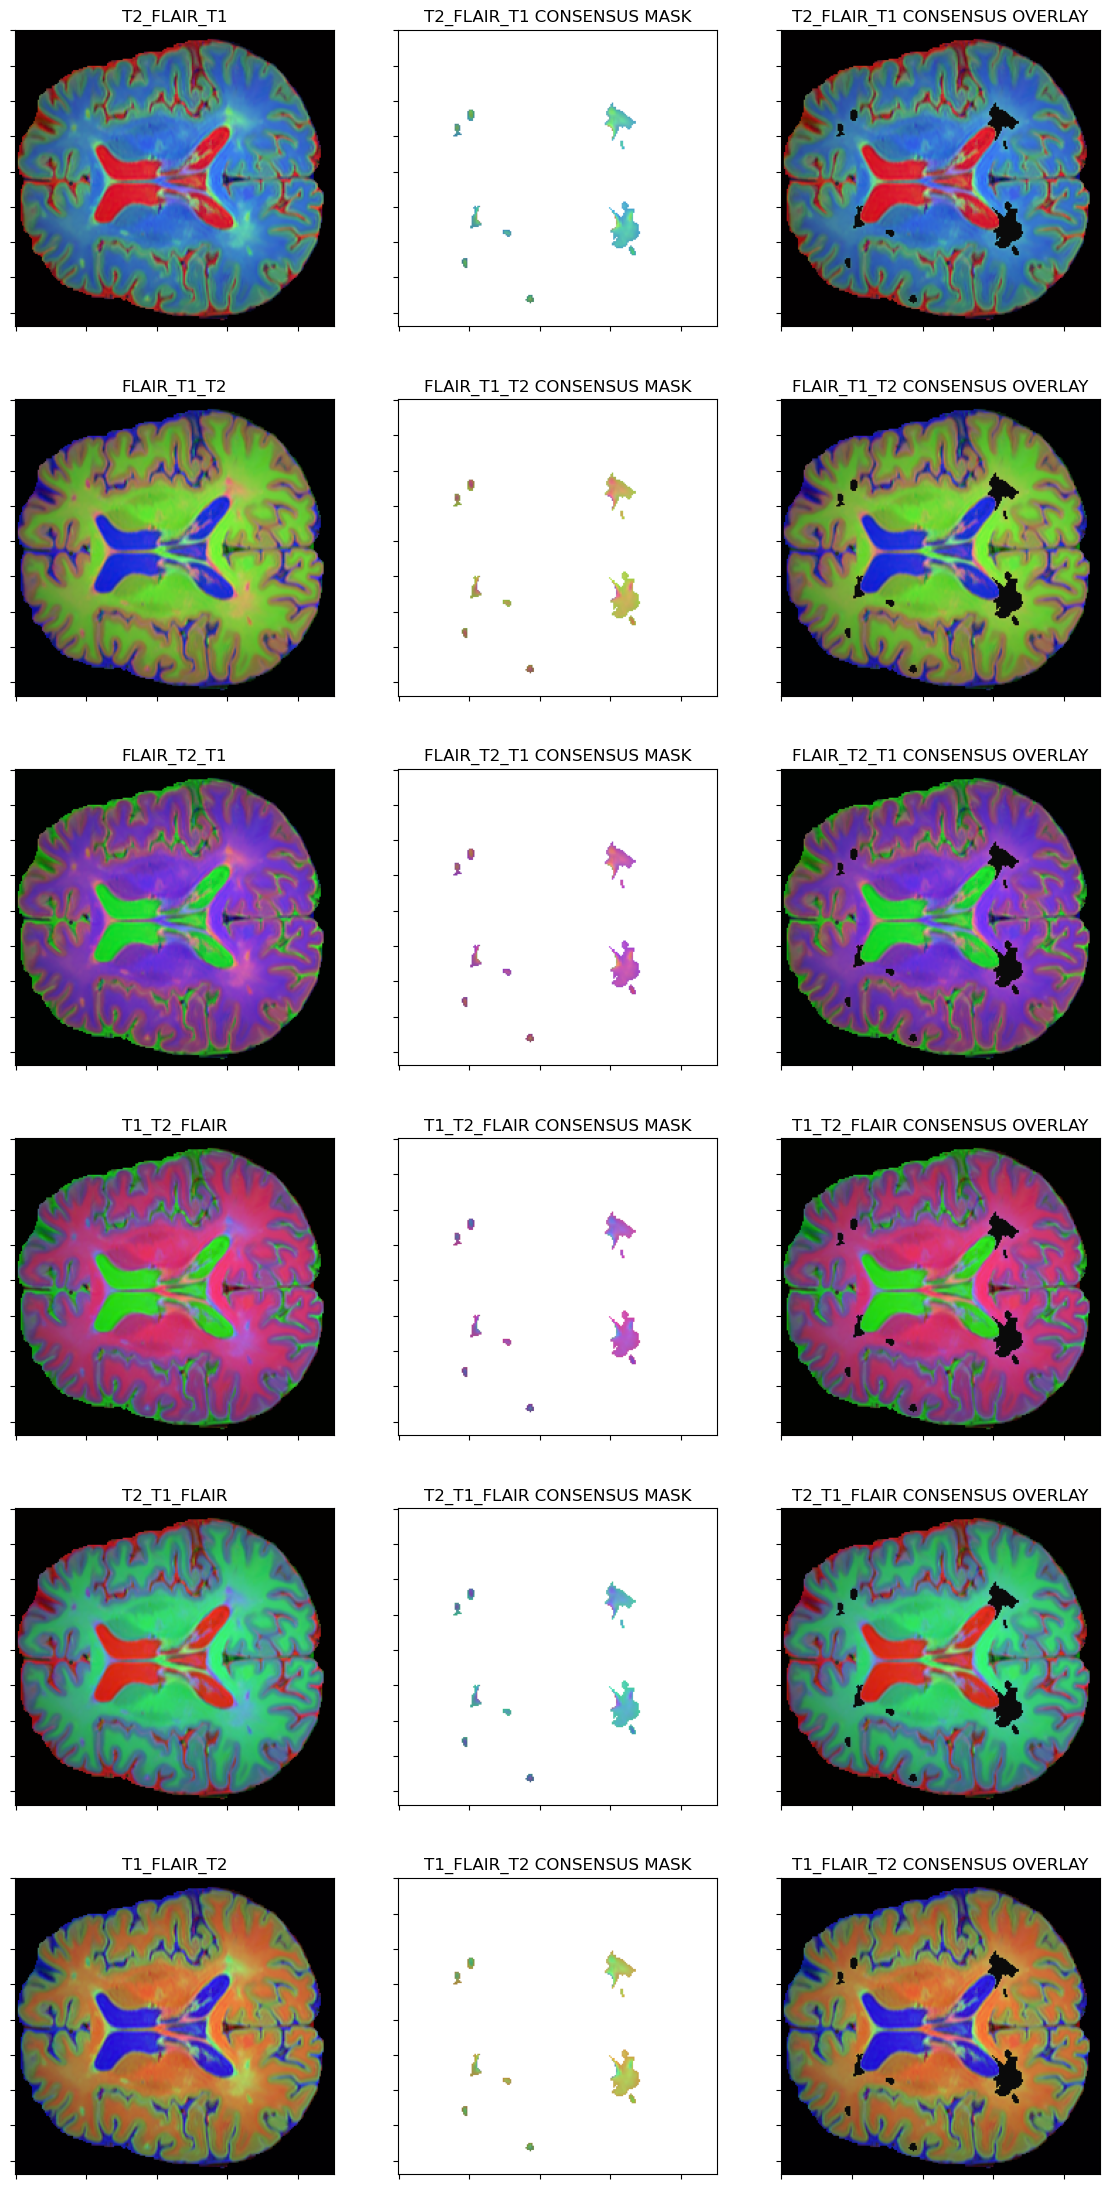

In [315]:
import os
from PIL import Image
import pylab as plt
import numpy as np

fig = plt.figure(figsize=(14, 28))
columns = 3
rows = 6
i = 1

def drop_extension_from_filename(filename):
    return os.path.splitext(filename)[0]

for filename in os.listdir(RGB_IMAGES_OUTPUT_FOLDER):
    with (Image.open(os.path.join(RGB_IMAGES_OUTPUT_FOLDER, filename))) as image:
        rgba_image = image.convert("RGBA")
        image_overlay = np.array(rgba_image)
        image_masked = np.array(rgba_image)

        for x in range(G_cropped_t1.height):
            for y in range(G_cropped_t1.width):
                if cropped_consensus_data[x][y] == 0:
                    image_masked[x][y][3] = 0
                else:
                    image_overlay[x][y] = [10, 10, 10, 255]

        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(drop_extension_from_filename(filename))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.imshow(np.asarray(image))
        i += 1

        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(drop_extension_from_filename(filename) + " CONSENSUS MASK")
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.imshow(image_masked)
        i += 1

        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(drop_extension_from_filename(filename) + " CONSENSUS OVERLAY")
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.imshow(image_overlay)
        i += 1

plt.show()

## Select a graph

Select the FLAIR_T1_T2 graph to use for the GNN.

In [316]:
flair_t1_t2_graph = G_graphs["FLAIR_T1_T2"]

## Build a Data object for pytorch geometric

To use the graph in pytorch geometric we have to build a Data object based on the properties of the graph we want to train on.

These are the parameters that we are going to specify:
- ```x```: data structure in which we define the features for each vertex
- ```edge_index```: data structure that contains the edges of the graph
- ```edge_attr```: contains the features for each edge
- ```y```: target to train against; labels of the vertices

### Node features (x)

Since we do not have features for the nodes, we are going to use a placeholder feature. For each node we are going to have one feature with a value of 1.

The required shape for this object is ```[num_nodes, num_node_features]```.

In [317]:
import torch
num_nodes = flair_t1_t2_graph.get_num_of_vertices()
feature_dim = 1

node_features = torch.ones((num_nodes, feature_dim), dtype=torch.float)

### Graph edges (edge_index)

Using the adjacency list from the graph, we build the edge_index object which has to have the shape ```[2, num_edges]```.

In [318]:
edge_index = np.array(flair_t1_t2_graph.get_adjacency_list()).T
edge_index = torch.tensor(edge_index, dtype=torch.long)

### Edges features (edge_attr)

Starting from the list of weight for the edges, we give it the shape ```[num_edges, num_edge_features]``` and then we normalize all the values.

In [319]:
def min_max_normalize(edge_features):
    min_val, max_val = flair_t1_t2_graph.get_min_max_weight()
    normalized = (edge_features - min_val) / (max_val - min_val)
    return normalized

edge_weights_list = flair_t1_t2_graph.get_edges_weight_list()
edge_attr = torch.tensor(edge_weights_list, dtype=torch.float)
edge_attr = min_max_normalize(edge_attr)

### Vertices labels (y)

For the labels we are going to use the consensus data. So, the value for the labels will be **0** and **1**. Since we have only one label, the required shape for this object is ```[num_nodes, 1]```.

In [320]:
labels = cropped_consensus_data.flatten()
labels = torch.tensor(labels, dtype=torch.float)

### Build the Data object and validate it

In [321]:
import torch
from torch_geometric.data import Data

train_mask = torch.ones(num_nodes, dtype=torch.bool)

data = Data(
    x=node_features,
    edge_index=edge_index,
    edge_attr=edge_attr,
    y=labels,
    num_nodes=num_nodes,
    num_classes=2,
    train_mask=train_mask
)
data.validate(raise_on_error=True)

True

### Some statistics about the graph

In [322]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 47460
Number of edges: 270646
Average node degree: 5.70
Number of features: 1
Number of classes: 2
Number of training nodes: 47460
Training node label rate: 1.00
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [323]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.nn import Linear

class GDPModel(torch.nn.Module):
    def __init__(self, num_features=3, hidden_size=32, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = 1),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim = 1)]
        self.linear = Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr) # edge features here as well
        x = self.linear(x)

        return F.relu(x)

model = GDPModel(0, 32, 1)

In [324]:
# import torch.nn.functional as F
# from torch_geometric.nn import GINConv, global_mean_pool
# from torch.nn import Sequential, Linear, ReLU

# class GINConvModel(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(GINConvModel, self).__init__()
#         nn1 = Sequential(Linear(in_channels, 64), ReLU(), Linear(64, 64))
#         self.conv1 = GINConv(nn1)
#         nn2 = Sequential(Linear(64, 64), ReLU(), Linear(64, out_channels))
#         self.conv2 = GINConv(nn2)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

# # Initialize the model
# model = GINConvModel(in_channels=data.num_node_features, out_channels=data.num_classes)

In [325]:
# import torch.optim as optim

# # Set up the optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# # Training loop
# for epoch in range(200):
#     loss = train()
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss:.4f}')

# # Evaluate the model
# model.eval()
# _, pred = model(data).max(dim=1)
# correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
# accuracy = int(correct) / int(data.train_mask.sum())
# print(f'Accuracy: {accuracy:.4f}')

In [326]:
# model = GDPModel(num_features=1, hidden_size=32, target_size=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# def train():
#     model.train()
#     optimizer.zero_grad()
#     output = model(data)
#     loss = criterion(output.squeeze(), data.y)
#     loss.backward()
#     optimizer.step()
#     print(f'Loss: {loss.item()}')

# # Run the training loop
# for epoch in range(10):  # Train for 10 epochs
#     print(f'Epoch {epoch+1}')
#     train()

# # Evaluate the model
# model.eval()
# _, pred = model(data).max(dim=1)
# correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
# accuracy = int(correct) / int(data.train_mask.sum())
# print(f'Accuracy: {accuracy:.4f}')